# Stock Trading Bot using Reinforcement Learning

To build a stock trading bot using Reinforcement Learning (Deep Q-Learning)

## Requirements
I used Google Colab with GPU support for this project. However, if you want to run this offline you'll need the following:

* Python 3
* Tensorflow 2.0
* Numpy
* Pandas
* Matplotlib
* Scikit-learn

#### Check GPU and import GDrive

In [1]:
!nvidia-smi

Sat Jan  4 13:01:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Necessary Imports

In [3]:
!pip install -q tensorflow-gpu==2.0.0

try:
  %tensorflow_version 2.x
except Exception:
  pass

     |████████████████████████████████| 380.8MB 27kB/s 
     |████████████████████████████████| 3.8MB 44.6MB/s 
     |████████████████████████████████| 450kB 74.7MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
TensorFlow 2.x selected.


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Import Dataset

In [0]:
def get_data():
  df = pd.read_csv('/content/gdrive/My Drive/stock_bot/stock_data.csv')
  return df.values

## Environment

  * Define an environment for the agent.<br>
  * Consider N stocks<br>
  * Define States: (Shares owned, Share prices, Cash)<br>
  * Define Actions: (Sell, Buy, Hold)<br>
  * For 3 stocks, we have 3^3 actions. So, we'd have 3^N actions for N stocks which is not scalable.<br>
  * Reward is nothing but change in value of portfolio<br>
  >                              Portfolio value = Number of shares * Share price + Cash


In [0]:
class MultiStockEnvironment:
  # This class mimics OpenAI Gym API
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations, store a list of permutated action elements
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()

  def reset(self):  
    # reset pointer to 0 and return initial state
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()

  def step(self, action):
    # perform the trade, move pointer
    # calculate reward, next state, portfolio value, done
    assert action in self.action_space

    # get current value before performing action
    prev_val = self._get_val()

    # update price (go to the next day)
    self.cur_step = self.cur_step + 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after performing trade
    cur_val = self._get_val()

    # reward, i.e, increase in portfolio value
    reward = cur_val - prev_val

    # set done flaf if we have run out of data
    done = self.cur_step==self.n_step-1

    # store the current value of portfolio
    info = {'cur_val': cur_val}

    return self._get_obs(), reward, done, info

  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs

  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

  def _trade(self, action):
      # index the action we want to perform
      # define action vector
      action_vector = self.action_list[action]

      # determine which stocks to buy or sell
      sell_index = []                                                           # stores index of stocks we want to sell
      buy_index = []                                                            # stores index of stocks we want to buy
      for i,a in enumerate(action_vector):
        if a==0:
          sell_index.append(i)
        elif a==2:
          buy_index.append(i)

      # sell any stocks (all shares of that stock) that we want to sell
      if sell_index:
        for i in sell_index:
          self.cash_in_hand = self.cash_in_hand + self.stock_price[i] * self.stock_owned[i]
          self.stock_owned[i] = 0

      # buy any stocks that we want to buy
      if buy_index:
        # buy one share in each stock until we run out of money
        buy_me = True
        while buy_me:
          for i in buy_index:
            if self.cash_in_hand > self.stock_price[i]:
              # buy one share of that stock
              self.stock_owned[i] = self.stock_owned[i] + 1
              self.cash_in_hand = self.cash_in_hand - self.stock_price[i]
            else:
              buy_me = False  

## Replay Buffer
* Buffer is nothing but a python list, having a static maximum size. <br>
* We'll be using Circular Queue Data Structure for this. <br>
* Each element is going to be a tuple consisting (s, a, r, s', done) values. <br>
* Add new tuples to the buffer as we encounter them. <br>
* When the maximum size is reeached, we need to throw the oldest value. (In python, by default **buffer.pop(0)** would be used for dequeue operation)<br>

### Steps to implement our own replay buffer:
* Pre-allocate fixed size arrays:
  * States (N*D)
  * Actions (N)
  * Rewards (N)
  * Next States (N*D)
  * Done Flag (N)
* Populate these arrays as we progress.  
* Use a pointer to tell us about where to store the next value.
* The replay buffer is going to be circular.
      

In [0]:
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    # Pre-allocating fixed size arrays of respective dimensions mentioned above as class data members
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)                 # to store state
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)                 # to store next state
    self.acts_buf = np.zeros(size, dtype=np.uint8)                              # to store actions
    self.rews_buf = np.zeros(size, dtype=np.float32)                            # to store rewards
    self.done_buf = np.zeros(size, dtype=np.uint8)                              # to store boolean values indicating done flag
    self.ptr = 0                                                                # initial value of pointer is 0, to use pointer to traverse through the queue from beginning
    self.size = 0                                                               # initial size of buffer
    self.max_size = size                                                        # maximum size of the buffer

  def store(self, obs, act, rew, next_obs, done):
    # store the values in their respective buffers
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    # increment pointer to move to next position in each buffer so we can store the next values
    self.ptr = (self.ptr+1) % self.max_size                                     # modulo operation for incrementing the pointer since the queue is going to be circular
    self.size = min(self.size+1, self.max_size)                                 # denotes memory/space of the buffer

  def sample_batch(self, batch_size=32):
    # return all the stored values randomly whenever called during training
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s1=self.obs1_buf[idxs], s2=self.obs2_buf[idxs], a=self.acts_buf[idxs], r=self.rews_buf[idxs], d=self.done_buf[idxs])  

## Neural Network Model

The Neural Network architecture is going to be a Multi-Layered Perceptron model which is going be trained and used by our agent to predict action (Regression).

In [0]:
def action_NN(input_dim, n_action, n_hidden_layers=1, hidden_dim=32):
  # input layer
  i = tf.keras.layers.Input(shape=(input_dim,))
  x = i 

  # hidden layers
  for layer in range(n_hidden_layers):
    x = tf.keras.layers.Dense(hidden_dim, activation='relu')(x)

  # output layer
  x = tf.keras.layers.Dense(n_action)(x)

  # create the fuctional API model
  model = tf.keras.models.Model(inputs=i, outputs=x)

  # compile the model 
  model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False))

  # print the NN architecture of the model
  # print((model.summary()))

  return model

## Agent

According to Computational Intelligence, an agent is something that perceives the environment through sensor/data and acts upon that environment through actuators (actions). 


In [0]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = ReplayBuffer(state_size, action_size, size=500)
    self.gamma = 0.95                                                           # discount rate
    self.epsilon = 1.0                                                          # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = action_NN(state_size, action_size)

  def update_replay_buffer(self, state, action, reward, next_state, done):
    # store in replay buffer
    self.memory.store(state, action, reward, next_state, done)

  def act(self, state):
    # calculate Q(s, a), take argmax over a
    # random choice of action
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)

    # predict action  
    act_values = self.model.predict(state)
    # return predicted action
    return np.argmax(act_values[0])  

  def replay(self, batch_size=32):
    # sample from replay buffer, make input-target pairs
    # model.train_on_batch(inputs, targets)

    # check if the replay buffer contains sufficient data
    if self.memory.size < batch_size:
      return      

    # sample a batch of data from the replay memory
    minibatch = self.memory.sample_batch(batch_size)
    states = minibatch['s1']
    next_states = minibatch['s2']
    actions = minibatch['a']
    rewards = minibatch['r']
    done = minibatch['d']

    # calculate tentative target Q(s', a)
    target = rewards + self.gamma * np.max(self.model.predict(next_states), axis=1)

    # set target to be reward only since value of terminal state is always 0
    target[done] = rewards[done]

    # Update/Reinforce training on the NN to update the network for actions which were actually taken
    # set target to prediction of all values
    # change the targets for action taken Q(s, a)
    target_full = self.model.predict(states)
    target_full[np.arange(batch_size), actions] = target

    # run one training step
    self.model.train_on_batch(states, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon = self.epsilon*self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)

  def save(self, name):
    self.model.save_weights(name)    

## Utility functions

**make_dir:** To make a directory to store the model and rewards, if the directory is not already present.

**plot_rewards:** Plot the rewards so we can analyze the stock trades

In [0]:
def make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
def plot_rewards(choice):
  a = np.load(f'{rewards_folder}/{choice}.npy')

  print(f"Average Reward: {a.mean():.2f} | Min: {a.min():.2f} | Max: {a.max():.2f}")

  plt.hist(a, bins=30)
  plt.title(choice)
  # plt.show()  

## Standardizing / Normalizing

The values in dataset might be anywhere from 0 to infinity. The more data near 1000's or 10000's or millions and less data near 0, is gonna cause **bias** during training and wouldn't perform well on input values that are closer to 0.

So, we need to scale the values in dataset such that all the values are centered around 0, i.e, scale from 0 to 1 or scale from -1 to 1. The values would follow Standard Distribution/Normal Distribution after scaling based on the statistical distrubutuion chosen for scaling.

**Normal Distribution:**

> Z = (X - μ) / σ

μ = Mean of data in the distribution<br>
σ = Variance

**Standard Normal Distribution** is a type of Normal Distribution with μ = 0 and σ = 1 


In [0]:
def get_scaler(env):
  # function to standardize values
  # returns scikit-learn's scaler object to scale the states
  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler    

## Perform and Learn 

The play_one_episode function plays the game and learns correspondingly for each episode when called.

In [0]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.update_replay_buffer(state, action, reward, next_state, done)
      agent.replay(batch_size)
    state = next_state

  return info['cur_val']

## Bot Main

Train and test the bot 

### Train

In [15]:
models_folder = '/content/gdrive/My Drive/stock_bot/trader_models/'
rewards_folder = '/content/gdrive/My Drive/stock_bot/trader_rewards/'
num_episodes = 500
batch_size = 32
initial_investment = 50000

make_dir(models_folder)
make_dir(rewards_folder)

data = get_data()
n_timesteps, n_stocks = data.shape

choice = 'train'

n_train = n_timesteps // 2

train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnvironment(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

# create empty list for storing final value of portfolio at the end of an episode
portfolio_value = []

if choice=='test':
  # then load previous scaler
  with open(f'{models_folder}/standard_scaler.dat', 'rb') as f:
    scaler = pickle.load(f)

  # reinstantiate environment with test data
  env = MultiStockEnvironment(test_data, initial_investment) 

  # reset epsilon, epsilon should not be 1 and no need to run multiple episodes if epsilon is 0
  agent.epsilon = 0.01

  # load trained weights of the NN model
  agent.load(f'{models_folder}/nn_agent.h5')

# play game for num_episode times
for e in range(num_episodes):
  t0 = datetime.now()
  val = play_one_episode(agent, env, choice)
  dt = datetime.now() - t0
  print(f"Episode {e+1}/{num_episodes}\nEpisode end value: {val:.2f}  |  Duration: {dt}")
  portfolio_value.append(val)                  

Episode 1/500
Episode end value: 86637.59  |  Duration: 0:00:31.280833
Episode 2/500
Episode end value: 68959.38  |  Duration: 0:00:35.012749
Episode 3/500
Episode end value: 105849.77  |  Duration: 0:00:34.065490
Episode 4/500
Episode end value: 54199.81  |  Duration: 0:00:34.123421
Episode 5/500
Episode end value: 75797.13  |  Duration: 0:00:33.638414
Episode 6/500
Episode end value: 52701.09  |  Duration: 0:00:33.745265
Episode 7/500
Episode end value: 52701.09  |  Duration: 0:00:33.194676
Episode 8/500
Episode end value: 57428.16  |  Duration: 0:00:33.494662
Episode 9/500
Episode end value: 108307.84  |  Duration: 0:00:32.995206
Episode 10/500
Episode end value: 86863.31  |  Duration: 0:00:32.870329
Episode 11/500
Episode end value: 64437.56  |  Duration: 0:00:32.863508
Episode 12/500
Episode end value: 57948.08  |  Duration: 0:00:33.074920
Episode 13/500
Episode end value: 65810.41  |  Duration: 0:00:33.016736
Episode 14/500
Episode end value: 67514.18  |  Duration: 0:00:33.105007

In [0]:
if choice=='train':
  # save the NN model
  agent.save(f'{models_folder}/nn_agent.h5')

  # save the scaler
  with open(f'{models_folder}/standard_scaler.dat', 'wb') as f:
    pickle.dump(scaler, f)

# save portfolio value of each episode
np.save(f'{rewards_folder}/{choice}.npy', portfolio_value)

Plot the rewards obtained during the training process

Average Reward: 102334.22 | Min: 52701.09 | Max: 146077.33


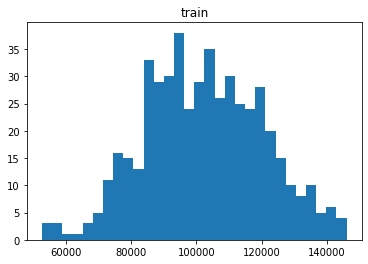

In [17]:
plot_rewards(choice)

### Test

In [18]:
num_episodes = 100
batch_size = 32
initial_investment = 30000

choice = 'test'

state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)

# create empty list for storing final value of portfolio at the end of an episode
portfolio_value = []

if choice=='test':
  # then load previous scaler
  with open(f'{models_folder}/standard_scaler.dat', 'rb') as f:
    scaler = pickle.load(f)

  # reinstantiate environment with test data
  env = MultiStockEnvironment(test_data, initial_investment) 

  # reset epsilon, epsilon should not be 1 and no need to run multiple episodes if epsilon is 0
  agent.epsilon = 0.01

  # load trained weights of the NN model
  agent.load(f'{models_folder}/nn_agent.h5')

# play game for num_episode times
for e in range(num_episodes):
  t0 = datetime.now()
  val = play_one_episode(agent, env, choice)
  dt = datetime.now() - t0
  print(f"Episode {e+1}/{num_episodes}\nEpisode end value: {val:.2f}  |  Duration: {dt}")
  portfolio_value.append(val)                 

# save portfolio value of each episode
np.save(f'{rewards_folder}/{choice}.npy', portfolio_value)

Episode 1/100
Episode end value: 45822.56  |  Duration: 0:00:11.451140
Episode 2/100
Episode end value: 45422.82  |  Duration: 0:00:11.499718
Episode 3/100
Episode end value: 47253.76  |  Duration: 0:00:11.686271
Episode 4/100
Episode end value: 41694.70  |  Duration: 0:00:11.431487
Episode 5/100
Episode end value: 38491.08  |  Duration: 0:00:11.510641
Episode 6/100
Episode end value: 45566.27  |  Duration: 0:00:11.778782
Episode 7/100
Episode end value: 43039.08  |  Duration: 0:00:11.565584
Episode 8/100
Episode end value: 41501.05  |  Duration: 0:00:11.481908
Episode 9/100
Episode end value: 37427.20  |  Duration: 0:00:11.527632
Episode 10/100
Episode end value: 46599.10  |  Duration: 0:00:11.628899
Episode 11/100
Episode end value: 33271.99  |  Duration: 0:00:11.834490
Episode 12/100
Episode end value: 41069.11  |  Duration: 0:00:11.861876
Episode 13/100
Episode end value: 46290.57  |  Duration: 0:00:11.927897
Episode 14/100
Episode end value: 42698.21  |  Duration: 0:00:11.778812
E

Plot the rewards obtained during the testing process

Average Reward: 43083.60 | Min: 32689.69 | Max: 57872.56


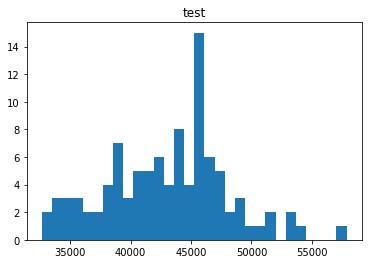

In [19]:
plot_rewards(choice)